# Ketamine VR5 - SINGLE LABELED DATA ONLY
#### Jonathan Ramos 2/1/2024

From the previous set of notebooks, we developed a new method to deal with negative intensity values. Rather than subtracting out the background to get an intenisty metric that takes into account the background fluorescence, I tried taking the ratio of the mean ROI intensity to the background intensity, generating an SNR value that (unlike the previous metric) cannot be negative. Next, visualizations of the distributions of intensity SNRs per stain type, along with visual inspection of actual image data (the "worst offenders," with the most negative intensity values) an acceptable SNR threshold was determined that removed ROIs whose SNR is too low to consider as a legitimate observation but still retains those dim ROIs that may still reasonably be considered as true observations of real cells (confirmed by AG, JR, and BS). Below are the plots of the SNR distributions, annotated with the SNR threshold.

For each stain type we determined the following SNR thresholds:
- PV : 0.8
- cFos : 0
- Npas4 : 0.8
- WFA : 0.85

As before, col names are different than older verions of these csvs, and some label names need to be changed; in particular, some stain type names are simply called "hand drawn" if the user added ROIs that were not detected by the polygon algorithm. This causes probems because all hand drawn ROIs of any stain type are all called "hand drawn." This has been an on going issue with polygon, but we have a work around. we have the following file naming scheme denoting stain types:
- *_2.tif : PV
- *_3.tif : cFos
- *_4.tif : Npas4
- *_5.tif : WFA

Additionally, since there is no subject ID col, we can construct it from informatively named filenames instead. For this project, filenames follow the following format:

*(rat number)*_*(brain region)*_*(bregma)*_*(n)*.tif


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# SNR distributions and thresholds

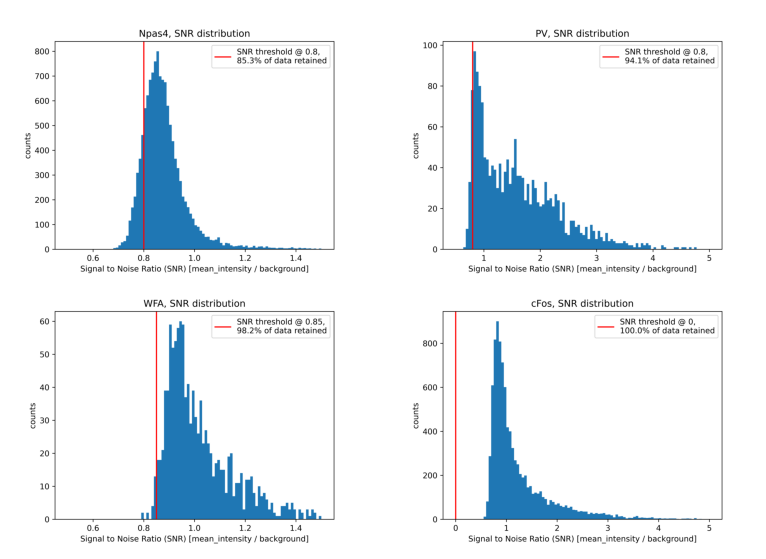

In [27]:
plots = glob.glob('SNR_distributions/*.png')
plots.sort()
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
ax = ax.flatten()
for i, p in enumerate(plots):
    img = mpimg.imread(p)
    ax[i].axis('off')
    ax[i].imshow(img)

plt.subplots_adjust(wspace=0, hspace=0)

# Cleaning, Wrangling Data
## loading data, stitching sets together
### loading re-exported images (previously contained weird doublet cells?)

Some of the images contained merged ROIs that needed to be separated. These csvs are just a subset of the original set that need to be replaced.

In [70]:
# load cohort key (there's a few empty rows at the end)
df_key = pd.read_csv('KETAMINE_COHORT KEY.csv').dropna()

# load data; get it all in one spot
df_full_rexp = pd.concat([pd.read_csv(f) for f in glob.glob('Re-exported Single Label Results/*.csv') if not 'batch_export' in f])

# col names begin with a whitespace char; let's remove all ' ' chars from col names
df_full_rexp.columns = [col.replace(' ', '') for col in df_full_rexp.columns]

# creating a new rat_n col
df_full_rexp['rat_n'] = df_full_rexp.filename.apply(lambda x: x.split('_')[0])\
    .replace({' ': ''}, regex=True) # for some reason, we have more leading whitespace chars

print(df_full_rexp.shape)
df_full_rexp.head()

(8966, 31)


,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,feret_min,circularity,aspect_ratio,roundness,solidity,skewness,kurtosis,filename,analysis_date,rat_n
0,1,000-00000,Parvalbumin,OVAL,319.08,144.05,418.0,131.7487,168.6701,160.6991,...,24.0,0.9240,1.0000,0.9330,0.9248,0.5867,-0.1199,PE-11-2_PFC_3.5_D_2.tif,Wed Jan 31 15:50:56 PST 2024,PE-11-2
1,2,000-00001,Parvalbumin,OVAL,31.73,328.8,594.0,131.7487,272.9869,287.9911,...,24.0,0.8860,1.4139,0.6564,0.9195,-0.5564,-0.1613,PE-11-2_PFC_3.5_D_2.tif,Wed Jan 31 15:50:56 PST 2024,PE-11-2
2,3,000-00002,Parvalbumin,OVAL,445.75,337.39,814.0,131.7487,261.7057,272.9207,...,34.0,0.7546,1.1768,0.6452,0.7551,-0.2054,-0.7996,PE-11-2_PFC_3.5_D_2.tif,Wed Jan 31 15:50:56 PST 2024,PE-11-2
3,4,000-00004,Parvalbumin,OVAL,461.01,67.83,559.0,131.7487,166.0359,164.1165,...,26.0,0.9055,1.1503,0.7941,0.9104,0.4279,-0.2238,PE-11-2_PFC_3.5_D_2.tif,Wed Jan 31 15:50:56 PST 2024,PE-11-2
4,5,000-00005,Parvalbumin,OVAL,369.54,336.05,547.0,131.7487,295.6375,299.3816,...,26.0,0.8237,1.2320,0.6852,0.8415,-0.2284,0.1015,PE-11-2_PFC_3.5_D_2.tif,Wed Jan 31 15:50:56 PST 2024,PE-11-2


### loading the orignal sets

In [71]:
# load data; get it all in one spot
df_full_orig = pd.concat([pd.read_csv(f) for f in glob.glob('Original Single Label Results/*/*.csv') if not 'batch_export' in f])

# col names begin with a whitespace char; let's remove all ' ' chars from col names
df_full_orig.columns = [col.replace(' ', '') for col in df_full_orig.columns]

# creating a new rat_n col
df_full_orig['rat_n'] = df_full_orig.filename.apply(lambda x: x.split('_')[0])\
    .replace({' ': ''}, regex=True) # for some reason, we have more leading whitespace chars

print(df_full_orig.shape)
df_full_orig.head()

(24613, 31)


,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,feret_min,circularity,aspect_ratio,roundness,solidity,skewness,kurtosis,filename,analysis_date,rat_n
0,1,000-00000,Parvalbumin,OVAL,120.64,307.06,665.0,285.8023,636.1711,677.3578,...,28.0,0.9387,1.1447,0.8205,0.9419,-0.4228,-0.6905,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024,PE-11-7
1,2,000-00001,Parvalbumin,OVAL,403.99,379.52,468.0,285.8023,412.1381,395.8835,...,24.0,0.8789,1.1555,0.7613,0.8797,0.4731,-0.5155,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024,PE-11-7
2,3,000-00002,Parvalbumin,OVAL,363.44,463.29,399.0,285.8023,369.5932,366.851,...,20.0,0.8698,1.4266,0.6299,0.9027,0.3051,-0.1709,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024,PE-11-7
3,4,000-00003,Parvalbumin,OVAL,68.43,322.91,550.0,285.8023,518.8725,540.6805,...,22.0,0.8089,1.6476,0.535,0.8814,-0.4078,-0.4258,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024,PE-11-7
4,5,000-00004,Parvalbumin,OVAL,386.72,251.18,524.0,285.8023,832.9809,920.6865,...,26.0,0.9146,1.0654,0.8539,0.9066,-0.6879,-0.6308,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024,PE-11-7


### replacing data from the orig set with new data from the rexp set
Not all data will be replaced, just a subset of images with weird ROIs that were reexamined

In [72]:
# Check that all the images in the rexp set were also in the in orig set
orig_fset = set(df_full_orig.filename)
rexp_fset = set(df_full_rexp.filename)
assert rexp_fset.issubset(orig_fset)

# toss fnames into list
orig_filenames = sorted(list(orig_fset))
rexp_filenames = sorted(list(rexp_fset))

# build dicts from fnames where key is fname and val is df for that image
d_orig = dict(zip(orig_filenames, [df_full_orig.query(f'filename == "{fname}"') for fname in orig_filenames]))
d_rexp = dict(zip(rexp_filenames, [df_full_rexp.query(f'filename == "{fname}"') for fname in rexp_filenames]))

# build new df from orig fnames unless rexp fname
df_full_repl = []
for fname in orig_filenames:
    
    # if fname not in rexp set, take from orig set
    if not fname in rexp_fset:
        df_full_repl.append(d_orig[fname])

    # else if fname in rexp, take from rexp set
    elif fname in rexp_fset:
        df_full_repl.append(d_rexp[fname])
    
    else:
        print('check your fnames')
    
df_full_repl = pd.concat(df_full_repl)
print(df_full_repl.shape)
df_full_repl

(24606, 31)


,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,feret_min,circularity,aspect_ratio,roundness,solidity,skewness,kurtosis,filename,analysis_date,rat_n
0,1,000-00000,Parvalbumin,OVAL,297.86,425.97,445.0,238.8715,536.8331,532.8803,...,26.0,0.8382,1.0,0.8241,0.8365,0.3764,0.0099,KET-10-12_PFC_3.7_A_2.tif,Wed Jan 31 15:25:23 PST 2024,KET-10-12
1,2,000-00001,Parvalbumin,OVAL,340.47,43.89,347.0,238.8715,314.9278,284.4379,...,20.0,0.8281,1.3061,0.6386,0.8505,1.102,1.0406,KET-10-12_PFC_3.7_A_2.tif,Wed Jan 31 15:25:23 PST 2024,KET-10-12
2,3,000-00002,Parvalbumin,OVAL,154.85,476.15,394.0,238.8715,324.0556,319.8348,...,18.0,0.9262,1.5236,0.6465,1.0051,0.2869,-0.2163,KET-10-12_PFC_3.7_A_2.tif,Wed Jan 31 15:25:23 PST 2024,KET-10-12
3,4,000-00003,Parvalbumin,OVAL,310.1,308.22,448.0,238.8715,346.0313,348.0024,...,24.0,0.9119,1.0799,0.8432,0.9143,0.1229,-0.5794,KET-10-12_PFC_3.7_A_2.tif,Wed Jan 31 15:25:23 PST 2024,KET-10-12
4,5,000-00004,Parvalbumin,OVAL,44.35,323.64,409.0,238.8715,429.6127,447.5739,...,24.0,0.9041,1.0,0.9129,0.9049,-0.4186,-0.3725,KET-10-12_PFC_3.7_A_2.tif,Wed Jan 31 15:25:23 PST 2024,KET-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,8,FFF-00008,hand-drawn,RECT,385.12,235.3,301.0,109.6097,119.2211,109.2203,...,26.0,0.3015,1.1538,0.3344,0.3859,1.3178,1.6348,PE-13-9_PFC_4.0_B_5.tif,Thu Jan 25 16:01:28 PST 2024,PE-13-9
8,9,FFF-00009,hand-drawn,RECT,409.79,230.66,551.0,109.6097,128.8761,118.2371,...,32.0,0.3533,1.1875,0.3816,0.4531,1.3937,2.2887,PE-13-9_PFC_4.0_B_5.tif,Thu Jan 25 16:01:28 PST 2024,PE-13-9
9,10,FFF-00010,hand-drawn,RECT,300.24,100.38,807.0,109.6097,123.828,112.8194,...,40.0,0.3062,1.275,0.3103,0.3956,1.4283,2.5977,PE-13-9_PFC_4.0_B_5.tif,Thu Jan 25 16:01:28 PST 2024,PE-13-9
10,11,FFF-00011,hand-drawn,RECT,414.17,44.01,835.0,109.6097,120.4709,107.1758,...,43.0,0.2907,1.2093,0.3088,0.3734,2.2281,7.2789,PE-13-9_PFC_4.0_B_5.tif,Thu Jan 25 16:01:28 PST 2024,PE-13-9


## Relabeling incorrect data

In [73]:
# there were some issues with the naming/cohort key 

# PE-12-7 was incorrectly labeled as PE-12-3; this was confirmed by JR and AG by checking slide books/hard copies of behavior data
df_full_repl['filename'] = df_full_repl.filename.replace({'PE-12-3': 'PE-12-7'}, regex=True)

# similarly KET-8-2 was incorrectly labeled as KET-8-5; this was confirmed by JR and AG  by checking slide books. this wouldn't really 
# change anything since they received the same treatment but let's just change it to the correct label anyway
df_full_repl['filename'] = df_full_repl.filename.replace({'KET-8-5': 'KET-8-2'}, regex=True)

# check result
assert df_full_repl.filename.str.contains('PE-12-3').sum() == 0
assert df_full_repl.filename.str.contains('PE-12-7').sum() != 0
assert df_full_repl.filename.str.contains('KET-8-5').sum() == 0
assert df_full_repl.filename.str.contains('KET-8-2').sum() != 0

## Building the necessary cols
In particular we will need a rat_n (sid) col, stain_type col, and a treatment col. the filename col functions as the image name (iid) col.

We need the following cols
- rat_n (sid)
- treatment
- filename (fid)
- imagename (iid)
- stain_type
- CoM_x
- CoM_y
- mean_intensity
- background

In [82]:
# creating a new rat_n col
df_full_repl['rat_n'] = df_full_repl.filename.apply(lambda x: x.split('_')[0])\
    .replace({' ': ''}, regex=True) # for some reason, we have more leading whitespace chars

# some checks. we want be sure that the structure of all our rat_n labels is consistent
# in particular, we expect something of the form 'PE-12-7', that is we have exactly
# two dashes '-' separating some letters, followed by two numbers
assert df_full_repl.rat_n.apply(lambda x: len(x.split('-')) == 3).sum() == len(df_full_repl)
assert df_full_repl.rat_n.apply(lambda x: x.split('-')[0].isalpha()).sum() == len(df_full_repl)
assert df_full_repl.rat_n.apply(lambda x: x.split('-')[1].isnumeric()).sum() == len(df_full_repl)
assert df_full_repl.rat_n.apply(lambda x: x.split('-')[2].isnumeric()).sum() == len(df_full_repl)

# building a cohort key dictionary from df_key
treatment = dict(zip(df_key.Subject, df_key.TX.replace({' ': '_'}, regex=True)))

# creating new treatment col by mapping from cohort key dict
df_full_repl['treatment'] = df_full_repl.rat_n.map(treatment)

# creating new stain_type col from filename
stains = {
    '.*_2.tif$' : 'PV',
    '.*_3.tif$' : 'cFos',
    '.*_4.tif$' : 'Npas4',
    '.*_5.tif$' : 'WFA'
}
df_full_repl['stain_type'] = df_full_repl.filename.replace(stains, regex=True)

# check that stain_type col contains the appropriate labels
assert set(df_full_repl.stain_type.unique()) == set(stains.values())

# building image name (iid) from file name (fid) col
df_full_repl['image_name'] = df_full_repl.filename.replace({'_[0-9]\.tif': ''}, regex=True)

# select only the cols we need
df_subset = df_full_repl[['rat_n', 'treatment', 'stain_type', 'filename', 'image_name',\
                           'CoM_x', 'CoM_y', 'mean_intensity', 'background']]

# let's take a look
print(df_subset.shape)
df_subset.head()

(24606, 9)


,rat_n,treatment,stain_type,filename,image_name,CoM_x,CoM_y,mean_intensity,background
0,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,297.86,425.97,536.8331,238.8715
1,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,340.47,43.89,314.9278,238.8715
2,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,154.85,476.15,324.0556,238.8715
3,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,310.1,308.22,346.0313,238.8715
4,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,44.35,323.64,429.6127,238.8715


## Dropping nans, duplicates

In [101]:
# which cols have nans, how many?
print('Nan per col:')
print(df_subset.isna().sum())
# it looks like we have no nans! nothing to drop here.

# how many duplicated rows do we have?
print('\nTotal n of duplicated rows:')
print(df_subset.duplicated().sum())

# it looks like we have 15 duplicated rows. let's take a look 
df_full_repl[df_subset.duplicated()].head()

# I'm not concerned about dropping these duplicates, so let's just toss em
df_cleaned = df_subset[~df_subset.duplicated()].reset_index()
assert df_cleaned.duplicated().sum() == 0

Nan per col:
rat_n             0
treatment         0
stain_type        0
filename          0
image_name        0
CoM_x             0
CoM_y             0
mean_intensity    0
background        0
dtype: int64

Total n of duplicated rows:
4


# Computing SNR, thresholding
## Build SNR col

In [104]:
df_cleaned['snr'] = df_cleaned.mean_intensity.astype('f') / df_cleaned.background.astype('f')

# let's take a look
df_cleaned.head()

,index,rat_n,treatment,stain_type,filename,image_name,CoM_x,CoM_y,mean_intensity,background,snr
0,0,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,297.86,425.97,536.8331,238.8715,2.247372
1,1,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,340.47,43.89,314.9278,238.8715,1.318398
2,2,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,154.85,476.15,324.0556,238.8715,1.356611
3,3,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,310.1,308.22,346.0313,238.8715,1.448609
4,4,KET-10-12,FR1_KET,PV,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,44.35,323.64,429.6127,238.8715,1.798510


## SNR Threshold
For each stain type we determined the following SNR thresholds:
- PV : 0.8
- cFos : 0
- Npas4 : 0.8
- WFA : 0.85


In [116]:
# build dict of snr thresholds
snr_threshold = {
    'PV': 0.8,
    'cFos': 0,
    'Npas4': 0.8,
    'WFA': 0.85
}

# remove rows that did not meet snr cutoff
df_threshold = pd.concat([df_cleaned.query(f'stain_type == "{stain}"').query(f'snr > {snr_threshold[stain]}') for stain in df_cleaned.stain_type.unique()])

print(df_threshold.shape)
for stain in df_threshold.stain_type.unique():
    df_stain = df_threshold.query(f'stain_type == "{stain}"')
    print(f'\n====={stain}=====')
    print(df_stain.snr.describe())

(22785, 11)

=====PV=====
count    1584.000000
mean        1.653108
std         0.741540
min         0.800121
25%         1.029869
50%         1.510717
75%         2.078999
max         7.886600
Name: snr, dtype: float64

=====cFos=====
count    9414.000000
mean        1.240181
std         0.658661
min         0.567019
25%         0.830541
50%         0.988808
75%         1.394864
max         6.719101
Name: snr, dtype: float64

=====Npas4=====
count    10655.000000
mean         0.901296
std          0.106535
min          0.800012
25%          0.840781
50%          0.876607
75%          0.925459
max          2.566882
Name: snr, dtype: float64

=====WFA=====
count    1132.000000
mean        1.038267
std         0.173653
min         0.851139
25%         0.926895
50%         0.985249
75%         1.097897
max         2.713506
Name: snr, dtype: float64


In [108]:
df_cleaned.stain_type.unique()

array(['PV', 'cFos', 'Npas4', 'WFA'], dtype=object)